#### Part 4: 
#### From the earlier Jupyter notebooks (parts 1 to 3), a data set was scraped from open source government data, pre-processed, divided into evaluation, training and testing sets before finally being "pickled"

#### In the notebook, I will focus on using the training data set to create models for the prediction of the "no of rainy days" per month, based on the independent variables listed below. 

The '2_Weather_Proc' data set includes details of ~460 different monthly time periods, recorded at the Change Climate Station. Here are the fields:

| Field          | Description|
|----------------|--------------------------------------------------------|
| Year-month                | Month and Year of Data Point                |
| temp_mean_daily_min       | The monthly and annual mean daily minimum temperature                                                               |
| temp_extremes_min         | The absolute extreme minimum air temperature|
| temp_mean_daily_max       | The monthly and annual mean daily maximum temperature                                                               |
| mean_temp                 | The monthly mean air temperature            |
| max_temperature           | The monthly extreme maximum air temperature |
| mean_sunshine_hrs         | The monthly mean sunshine hours in a day    |
| wet_bulb_temperature      | The hourly wet bulb temperature             |
| maximum_rainfall_in_a_day | The highest daily total rainfall            |
| total_rainfall            | The total monthly rainfall                  |
| rh_extremes_minimum       | The absolute extreme minimum relative humidity                                                                  |
| mean_rh                   | The monthly mean relative humidity          |
| no_of_rainy_days          | The number of rain days (day with rainfall amount of 0.2mm or more)                                                  |
| prob_rain                 | A grouping of rainy days into x<5 (grp 0), 5< x <15 (grp 1) and x>15 (grp 2)                                           |

Note that 'no_of_rainy_days' and 'prob_rain' are the 2 dependent variables for determination

### Import Libraries

In [1]:
# General Libraries
import itertools
import time
import pickle
import os
import glob
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
%matplotlib inline

import seaborn as sns
sns.set()

from datetime import timedelta, date 

# Sklearn Liraries
from sklearn import preprocessing
from sklearn.externals.six import StringIO
# For scoring of classifiers
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# For decision tree
from sklearn import tree
import pydotplus

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
start = time.time()
print('Libraries imported')

C:\Users\quant\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Libraries imported


### Load Data from Pickled Files earlier

In [2]:
# Unpickle all the training (post normalization) 
# and testing data sets

X_train = pickle.load(open("X_train", "rb"))
print('Normalized X Training Set: ', X_train[0:5])
print('Shape X Training Set: ', X_train.shape)

X_test = pickle.load(open("X_test", "rb"))
print('Normalized X Testing Set: ', X_test[0:5])
print('Shape X Testing Set: ', X_test.shape)

y_train  = pickle.load(open("y_train", "rb"))
print('Y Training Set: ', y_train[0:5])
print('Shape Y Training Set: ', y_train.shape)

y_test  = pickle.load(open("y_test", "rb"))
print('Y Testing Set: ', y_test[0:5])
print('Shape Y Testing Set: ', y_test.shape)

y_train_bool  = pickle.load(open("y_train_bool", "rb"))
print('Y Boolean Training Set: ', y_train_bool[0:5])
print('Shape Y Boolean Training Set: ', y_train_bool.shape)

y_test_bool  = pickle.load(open("y_test_bool", "rb"))
print('Y Boolean Testing Set: ', y_test_bool[0:5])
print('Shape Y Boolean Testing Set: ', y_test_bool.shape)

validate_set  = pickle.load(open("validate_set", "rb"))
print('Validation Set: ', validate_set[0:5])
print('Shape Validation Set: ', validate_set.shape)

Normalized X Training Set:  [[ 6.94110442e-01  7.58334407e-01 -8.60576834e-01 -5.70372227e-01
  -2.07975746e-01 -1.71111308e+00 -2.44102219e-01  1.41694158e+00
   1.02884119e-04  6.18854018e-01  7.39994498e-01  1.34043480e+00]
 [ 1.19026850e+00 -2.00798406e+00 -1.77687447e+00 -2.29384697e+00
  -2.21173332e+00 -1.36948403e+00 -5.90526737e-01  2.87063675e+00
   2.62127817e+00  1.36090583e+00  1.07752961e+00 -1.25470932e+00]
 [ 3.63338401e-01 -3.20422989e-02  1.88831607e+00  1.02999718e+00
   1.91364992e+00  9.36512073e-01  2.75534559e-01 -1.06949455e+00
  -1.01337085e+00 -2.16384026e+00 -1.22384617e+00 -6.78010627e-01]
 [ 8.59496462e-01 -2.00798406e+00 -2.87890811e-01 -6.93477566e-01
  -5.61580023e-01 -1.73782346e-01 -7.63738996e-01 -7.63601164e-01
  -5.71030869e-01  6.23151615e-02  3.71774373e-01  1.05208546e+00]
 [ 1.02488248e+00  2.31416603e-01 -1.31872565e+00 -1.30900426e+00
  -9.15184300e-01 -2.22355666e+00 -4.17314478e-01  9.06183822e-01
   2.55910186e+00  8.04366970e-01  1.8446548

#### Function for plotting data - Distribution and Scatter Plot

In [3]:
def DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, plot_type): 
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)

    hist = True
    color1 = "red"
    color2 = "blue"
    color3 = "green"
    lw = 3
    
    if plot_type == 1:
        ax1 = sns.distplot(RedFunction, hist=hist, color=color1, label=RedName,
                           kde_kws={"color": color1, "lw": lw})
        ax2 = sns.distplot(BlueFunction, hist=hist, color=color2, label=BlueName, 
                           ax=ax1, kde_kws={"color": color2, "lw": lw})
    elif plot_type == 2:            
        plt.scatter(RedFunction, BlueFunction, label="Test vs Predicted",
                    s=25, c = color3, zorder=10)
        
        xymax = round(max(RedFunction.max()+5, BlueFunction.max()+5), -1)

        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        #plt.axes().set_aspect('equal')
        plt.xlim(0, xymax)
        plt.ylim(0, xymax)  
       
    plt.title(Title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.show()
    plt.close()

#### Function for plotting data - Dual Plot

In [4]:
def max_value(inputlist):
    return max([sublist[-1] for sublist in inputlist])

def min_value(inputlist):
    return min([sublist[-1] for sublist in inputlist])

def dual_plot(xvalue, yvalue, label, color, lw, 
              width, height, Title, xlabel, ylabel):
    plt.figure(figsize=(width, height))

    for i in range(len(yvalue)):
        xmax = round(max(xvalue)+1)
        xmin = round(min(xvalue)-1)
        ymax = round(max_value(yvalue)+1)
        ymin = round(min_value(yvalue)-1)
        plt.plot(xvalue, yvalue[i], label=label[i], 
                 color=color[i], linewidth=lw)
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)       
    plt.title(Title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.show()
    plt.close()    
    return

#### Residual plot the actual vs test values 

In [5]:
def res_plot(RedFunction, BlueFunction, xlabel, ylabel):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    cmap = sns.cubehelix_palette(dark=.9, light=.1, as_cmap=True)
    sns.residplot(RedFunction, BlueFunction, ax=ax, label = "Residual",
                  scatter_kws={"cmap": cmap}, lowess=True, color='r')
    ax.set_title('Residual between Predicted and Test set')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return

6 different Supervised Machine Learning models will be attempted. The first 3 are (what I term for this work) "basic":
1. Multilinear Regression
2. Polynomial Regression
3. Ridge Regression

The more "advanced" models are:
4. K Nearest Neighbours
5. Decision Tree
6. Support Vector Machine

I will also apply a neural net using Tensorflow and see if prediction accuracy improves. In this case, the neural net will be used on both the 'no_of_rainy_days' and 'prob_rain' to determine the limits of the method

## 1. Multilinear Regression

In [6]:
from sklearn import linear_model

# Train model on training set. Note that data set must be in nparray format
regr = linear_model.LinearRegression()
x_MLR = np.asanyarray(X_train)
y_MLR = np.asanyarray(y_train)
regr.fit(x_MLR, y_MLR)

# Prediction on test set
yhat_MLR = regr.predict(X_test)

# Coefficients
print('Coefficients: ', regr.coef_)
# Intercepts
print('Intercepts: ', regr.intercept_)

# Mean Absolute Error
#a = np.mean(np.absolute(yhat_MLR-y_test))
#print('Mean Absolute Error: {:.2f}'.format(a))
# Residual sum of Squares/ Mean Squared Error (MSE)
#b = np.mean((yhat_MLR-y_test)**2)
#print('Mean Squared Error: {:.2f}'.format(b))
# Variance: 1 is perfect prediction
#c = regr.score(x_MLR, y_MLR)
#print('Variance: {:.2f}'.format(c))
# R2 Error
#d = r2_score(yhat_MLR, y_test)
#print('R2-error: {:.2f}'.format(d))

e = regr.score(X_train, y_train)
print('R2-error of Training Set: {:.3f}'.format(e))
f = regr.score(X_test, y_test)
print('R2-error of Testing Data: {:.3f}'.format(f))

print("Pred values:", yhat_MLR[0:5].round(1))
print("True values:", y_test[0:5].round(1))

Coefficients:  [-0.2989     -0.0645329  -1.0958756   0.92474553  0.28369063 -1.09150631
  0.49192873 -1.63282003  3.25745405 -0.31859577  0.97401617  0.76023392]
Intercepts:  14.015444015444015
R2-error of Training Set: 0.690
R2-error of Testing Data: 0.631
Pred values: [ 9.2 10.8 16.9 20.7 15.3]
True values: [13. 14. 17. 21. 16.]


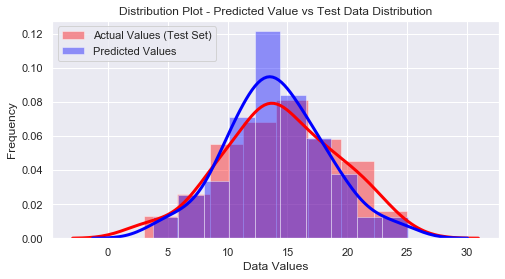

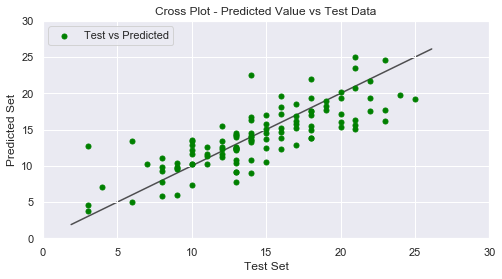

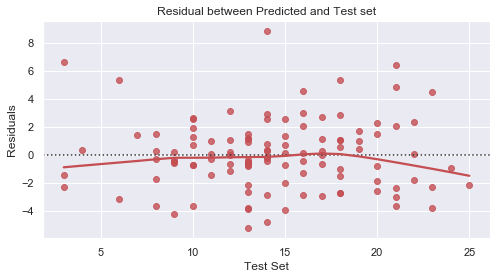

In [7]:
RedFunction = y_test # Test Data Set
BlueFunction = yhat_MLR # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

## 2. Second-Order Polynomial Regression

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# Cast the train nparray format data to new variables
x_train_poly = x_MLR
y_train_poly = y_MLR

x_test_poly = np.asanyarray(X_test)
y_test_poly = np.asanyarray(y_test)

poly = PolynomialFeatures(degree=2)
# Takes the x-values, raises them to degree=n
X_train_poly = poly.fit_transform(x_train_poly)
X_test_poly = poly.fit_transform(x_test_poly)
# Displays the matrix of the powers applied to each number
#print (poly.powers_)

# Polyfit is special case of MLR, therefore use 
# sklearn.linear_model.LinearRegression()
clf = linear_model.LinearRegression()
Y_train_poly = clf.fit(X_train_poly, y_train_poly)

# Coefficients, just the first 3.
print('First 3 Coefficients: ', clf.coef_[:3])
print('Total Number of Coefficients: ', len(clf.coef_))
# Intercepts
print('Intercepts: ', clf.intercept_)

# Prediction
yhat_poly = clf.predict(X_test_poly)

# Calculate R2 of the training and test data - goodness of fit
e1 = clf.score(X_train_poly, y_train_poly)
print('R2-error of Training Set: {:.3f}'.format(e1))
f1 = clf.score(X_test_poly, y_test_poly)
print('R2-error of Testing Data: {:.3f}'.format(f1))

print("Pred values:", yhat_poly[0:5].round(1))
print("True values:", y_test_poly[0:5].round(1))

First 3 Coefficients:  [ 1.21300472e-12 -5.22505719e-01  1.64421745e-01]
Total Number of Coefficients:  91
Intercepts:  15.200809859822757
R2-error of Training Set: 0.838
R2-error of Testing Data: 0.515
Pred values: [ 9.5 12.6 18.9 20.4 16.1]
True values: [13. 14. 17. 21. 16.]


#### Plot the actual vs test values 

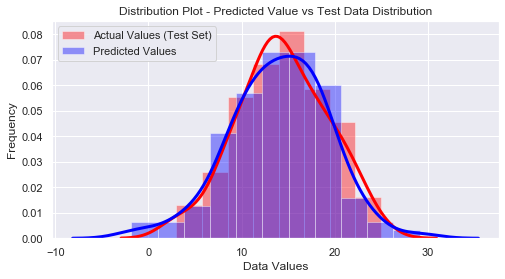

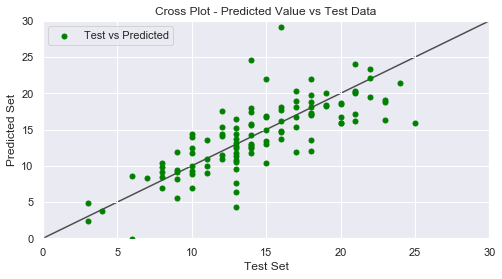

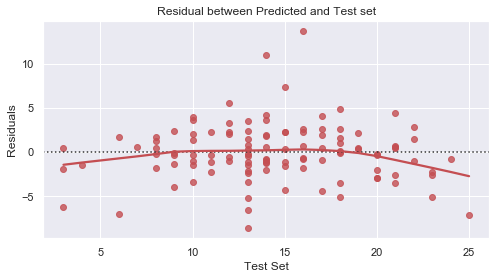

In [9]:
RedFunction = y_test_poly # Test Data Set
BlueFunction = yhat_poly # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

#### Plot the actual vs test values 

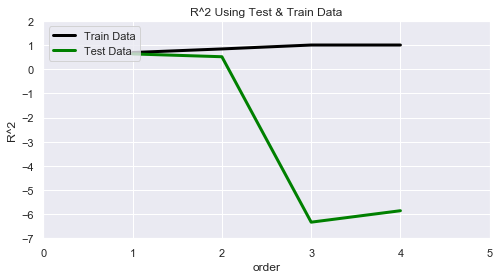

In [10]:
# Is a 2nd order polynomial the best?
Rsqu_test = []
Rsqu_train = []
yvalue = []
label = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train_poly)
    x_test_pr = pr.fit_transform(x_test_poly)
    
    clf.fit(x_train_pr, y_train_poly)
    
    Rsqu_test.append(clf.score(x_test_pr, y_test_poly))
    Rsqu_train.append(clf.score(x_train_pr, y_train_poly))
    
Title = 'R^2 Using Test & Train Data'
xlabel = 'order'
ylabel = 'R^2'
width = 8
height = width/2    
color = ["black", "green", "orange", "red"]
lw = 3

xvalue = order
yvalue.append(Rsqu_train) # Train Data Set
label.append("Train Data" )
yvalue.append(Rsqu_test) # Test Data Set
label.append("Test Data")
dual_plot(xvalue, yvalue, label, color, lw, 
          width, height, Title, xlabel, ylabel)

## 3. Ridge Regression

This data set may suffer from multicolliniarity. To address this, I will model the data to a ridge regression. The alpha term is important for the ridge regression, but since we dont know what a good value to use is,
I will use Gridsearch to find the best value for this hyperparameter.

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

pr=PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train_poly)
x_test_pr = pr.fit_transform(x_test_poly)

alpha_param = [{'alpha': [(10**x) for x in range(-4, 7)]}]
RM = Ridge()
Grid1 = GridSearchCV(RM, alpha_param, cv = 4)

Grid1.fit(x_train_pr, y_train_poly)
BestRR=Grid1.best_estimator_
print("Best Estimator for alpha: ", BestRR)

# Coefficients, just the first 3.
print('First 3 Coefficients: ', BestRR.coef_[:3])
print('Total Number of Coefficients: ', len(BestRR.coef_))
# Intercepts
print('Intercepts: ', BestRR.intercept_)

# Prediction
yhat_poly = BestRR.predict(x_test_pr)

# Calculate R2 of the training and test data - goodness of fit
e2 = BestRR.score(X_train_poly, y_train_poly)
print('R2-error of Training Set: {:.3f}'.format(e2))
f2 = BestRR.score(x_test_pr, y_test_poly)
print('R2-error of Testing Data: {:.3f}'.format(f2))

print("Pred values:", yhat_poly[0:5].round(1))
print("True values:", y_test_poly[0:5].round(1))

Best Estimator for alpha:  Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
First 3 Coefficients:  [ 0.         -0.496058    0.03403349]
Total Number of Coefficients:  91
Intercepts:  15.11047556288614
R2-error of Training Set: 0.812
R2-error of Testing Data: 0.671
Pred values: [ 9.4 10.9 17.6 22.1 15.2]
True values: [13. 14. 17. 21. 16.]


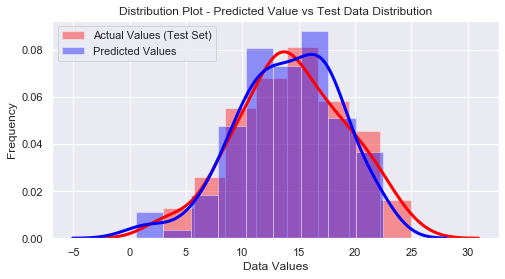

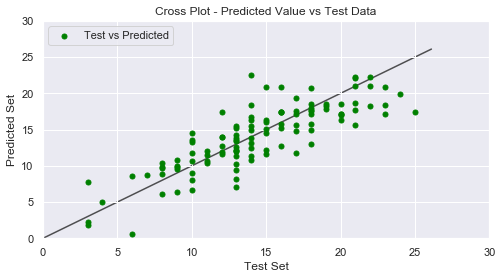

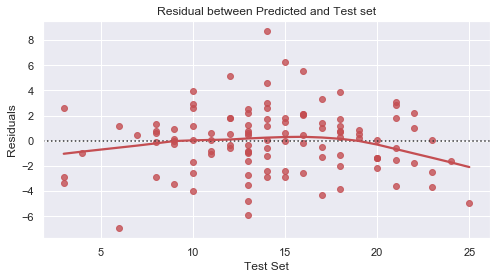

In [12]:
RedFunction = y_test_poly # Test Data Set
BlueFunction = yhat_poly # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

Title = 'Cross Plot - Predicted Value vs Test Data'
xlabel = 'Test Set'
ylabel = 'Predicted Set'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 2)

ylabel = 'Residuals'
res_plot(RedFunction, BlueFunction, xlabel, ylabel)

Based on the R2 values, we generally observe that:

1. The Ridge regression does similarly well to the Multilinear regression in predicting values; while the Multilinear regression has a low R2 on the testing data set as compared to the Ridge regression, the R2 on the test data sets are similar

2. The Polynomial regression and the Ridge regression are potentially overfitting data on the training data set; this is because we see a degredation in R2 values on the test data. However, the degradation in R2 is worse with the polynomial regression.

3. All 3 models have an accuracy of ~0.6 on the testing data set, but the best accuracy of the 3 comes from the Ridge Regression, at ~0.69.

#### Pickle the "Basic" Models as a Checkpoint

In [13]:
# Pickle multi-linear regression model
with open('model_MLR', 'wb') as file:
    pickle.dump(regr, file)
    
# Pickle polynomial regression model
with open('model_poly', 'wb') as file:
    pickle.dump(clf, file)
    
# Pickle Ridge regression model
with open('model_ridgeR', 'wb') as file:
    pickle.dump(BestRR, file)

#### The 3 regression methods shown above try to predict the exact number of rainy days. However, what if this was not needed; rather, it was more important to find out if: 

1. Total Number of Rain Days < 5
2. Total Number of Rain Days between 5-15
4. Total Number of Rain Days > 15

#### The best way to do this would be using a generalized clustering algorithm like KNN, a Decision Tree or a Support Vector Machine.

## 4. K Nearest Neighbours (KNN)

The implementation of this algorithm is complicated only by the fact that I dont know what k is the best to use. I will determine this using a loop with a few values, and look at the accuracy plot.

##### Note that in an earlier piece of work (not shown here), I applied KNN predict 'number of rainy days'. The accuracy was very poor, at <0.23. However, as seen below, grouping the data prior to KNN increases the accuracy to almost 0.7

In [14]:
from sklearn.neighbors import KNeighborsClassifier

K = 10
mean_acc = np.zeros((K-1))
fscore = np.zeros((K-1))
conf_mat = np.zeros((K-1))

std_acc = np.zeros((K-1))
Confusemat = []

In [15]:
for i in range(1,K):
    # Train the model
    neigh = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train_bool)
    yhat_KNN = neigh.predict(X_test)
    
    mean_acc[i-1] = accuracy_score(y_test_bool, yhat_KNN)
    fscore[i-1] = f1_score(y_test_bool, yhat_KNN, average='weighted')
    
    # np.std(yhat == y_test):
    # A comparison of two numpy arrays returns a boolean array. 
    # Booleans values are converted into 1(True) and 0 (false) intrinsically
    # / np.sqrt(yhat.shape[0])
    # taking the std of boolean array & dividing that by the 
    # square root length of that array.
    std_acc[i-1] = np.std(yhat_KNN == y_test_bool)/np.sqrt(yhat_KNN.shape[0])

print('Mean Accuracy:', mean_acc)
print('\n')
print('F1 Score:', fscore)
print('\n')
#print('Log Loss:', lloss)
print('F1 Score:\n',classification_report(y_test_bool, yhat_KNN))

Mean Accuracy: [0.74107143 0.71428571 0.74107143 0.76785714 0.8125     0.8125
 0.79464286 0.79464286 0.78571429]


F1 Score: [0.74244657 0.70684986 0.73615396 0.7645866  0.80686813 0.80660796
 0.78923993 0.78804407 0.77123859]


F1 Score:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.75      0.86      0.80        57
           2       0.83      0.76      0.80        51

    accuracy                           0.79       112
   macro avg       0.53      0.54      0.53       112
weighted avg       0.76      0.79      0.77       112



C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


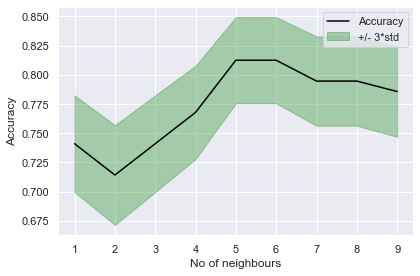

In [16]:
plt.plot(range(1,K), mean_acc, 'black')
plt.fill_between(range(1,K), 
                 mean_acc - 1*std_acc, 
                 mean_acc + 1*std_acc,
                 alpha = 0.3,
                 color = 'green')
plt.legend(('Accuracy', '+/- 3*std'))
plt.ylabel('Accuracy')
plt.xlabel('No of neighbours')
plt.tight_layout()
plt.show()

Ideal number of k is either 3, 5 or 7 for max accuracy (they have very similar values). It does much better than the linear regression model, but recall that this model does not predict individual days, but rather, categories which it will fall into. in thsi work, I will use k=3.

In [17]:
n_neighbors=5

neigh = KNeighborsClassifier(
    n_neighbors=n_neighbors).fit(X_train, y_train_bool)
yhat_KNN = neigh.predict(X_test)

mean_acc_KNN = accuracy_score(y_test_bool, yhat_KNN)
conf_mat_KNN = confusion_matrix(y_test_bool, yhat_KNN)
fscore_KNN = f1_score(y_test_bool, yhat_KNN, average='weighted')

print('Mean Accuracy:', mean_acc_KNN)
print('\n')
print('F1 Score:\n',classification_report(y_test_bool, yhat_KNN))

print("Pred values:", yhat_KNN[0:5].round(1))
print("True values:", y_test_bool[0:5].round(1))

Mean Accuracy: 0.8125


F1 Score:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.80      0.84      0.82        57
           2       0.82      0.82      0.82        51

    accuracy                           0.81       112
   macro avg       0.87      0.64      0.68       112
weighted avg       0.82      0.81      0.81       112

Pred values: [1 1 2 2 1]
True values: [1 1 2 2 2]


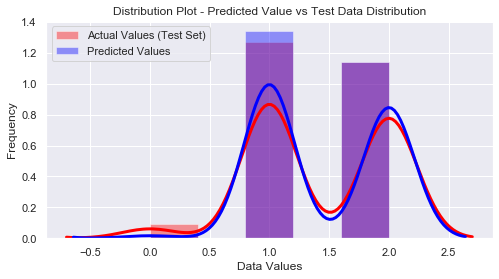

In [18]:
RedFunction = y_test_bool # Test Data Set
BlueFunction = yhat_KNN # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

The frequency distribuion is trimodal as expected, and it general, the peaks appear to be tracking, but there is little else that can be said. In this case, a confusion matrix may be more valuable as it allows me to visualize the algorithm performance. If you refer to the "classification_report" table above, I have tablulated if the predicictions are right or wrong based on wheter they are:

1. TN / True Negative: when a case was negative and predicted negative
2. TP / True Positive: when a case was positive and predicted positive
3. FN / False Negative: when a case was positive but predicted negative
4. FP / False Positive: when a case was negative but predicted positive
 - Precision = TP/(TP + FP)
 - Recall = TP/(TP + FN)
 - F1 Score = 2*(Recall * Precision) / (Recall + Precision)
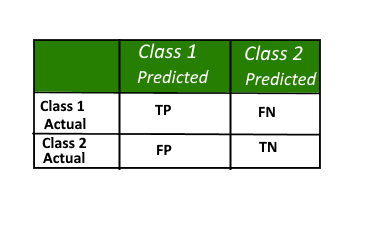

In [19]:
def plot_conf_mat(cnf_matrix, classes, normalize, cmap, width, height):
    plt.figure(figsize=(width, height))
    if normalize == True:
        # np.newaxis - make it as column vector by inserting an axis 
        # along second dimension
        cnf_matrix = cnf_matrix.astype('float')/ cnf_matrix.sum(
            axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, non-normalized")
    
    #imshow() - creates image from 2D numpy array.
    plt.imshow(cnf_matrix, interpolation = 'nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks (tick_marks, classes, rotation=45)
    plt.yticks (tick_marks, classes)
    
    fmt = '.2f'if normalize else 'd'
    thres = cnf_matrix.max()/2
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment='center',
                 fontsize=20,
                 color = 'yellow' if cnf_matrix[i, j] > thres else 'white'
                )
    # plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(None)
    return

Confusion Matrix, non-normalized


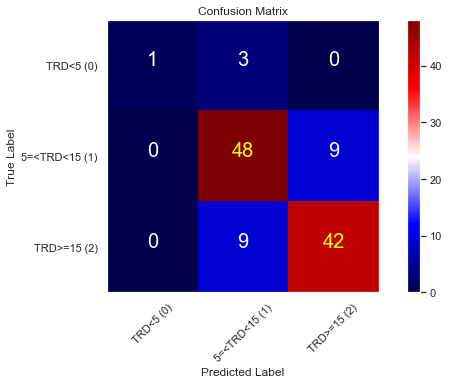

In [20]:
# Set normalize to true for the confusion matrix to print normalized values
# Call Total Rain Days = TRD
normalize = False
cmap = plt.cm.seismic
width=10
height=width/2

plot_conf_mat(conf_mat_KNN, 
              classes=['TRD<5 (0)', 
                       '5=<TRD<15 (1)', 
                       'TRD>=15 (2)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

From the confusion matrix, a total of 22 out of 114 points are predicted incorrectly, for an accuracy of ~0.74.

## 5. Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

# criterion="entropy" so that we can see inforamtion gain at each node
trd_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

trd_tree.fit(X_train, y_train_bool)
yhat_tree = trd_tree.predict(X_test)

print("Pred values:", yhat_tree[0:5].round(1))
print("True values:", y_test_bool[0:5].round(1))

print("Decision Tree Accuracy:", accuracy_score(y_test_bool, yhat_tree))

Pred values: [1 1 1 2 1]
True values: [1 1 2 2 2]
Decision Tree Accuracy: 0.75


In [22]:
weat_data = pd.read_csv("3_Weather_ML.csv")
weat_data.columns

Index(['Year-month', 'temp_mean_daily_min', 'temp_extremes_min',
       'temp_mean_daily_max', 'mean_temp', 'max_temperature',
       'mean_sunshine_hrs', 'wet_bulb_temperature',
       'maximum_rainfall_in_a_day', 'total_rainfall', 'rh_extremes_minimum',
       'mean_rh', 'no_of_rainy_days', 'Prob_rain'],
      dtype='object')

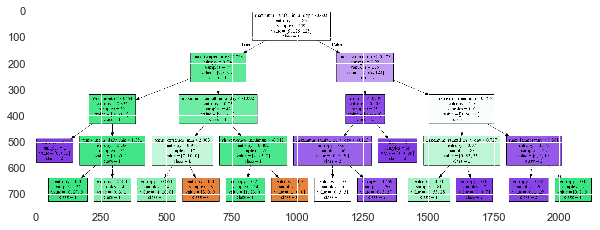

In [23]:
dot_data = StringIO()
fname = 'decision_tree.png'
featurenm = weat_data.columns[0:12]
targetnm = weat_data['Prob_rain'].unique().tolist()

out = tree.export_graphviz(
    trd_tree, 
    feature_names = featurenm, 
    out_file = dot_data, 
    class_names = np.unique(y_test_bool).astype(str), 
    filled=True, 
    special_characters = True, 
    rotate = False
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# To write to file
graph.write_png(fname)
img = mpimg.imread(fname)
plt.figure(figsize=(width, height))
plt.imshow(img, interpolation='nearest')

The predicion accuracy with the Decision Tree is ~0.75. However, if you look at the decision tree, not all variables were used in group the data. In this case, it might be ideal to try to map the variable to a higher dimension space and apply a SVM algorithm.

## 6. Support Vector Machine

The kernel function is an unknown; i will use a radial basis function (RBF) as the default

In [24]:
from sklearn import svm
model_svm = svm.SVC(kernel = 'rbf')
model_svm.fit(X_train, y_train_bool)

yhat_svm = model_svm.predict(X_test)

print("Pred values:", yhat_svm[0:5].round(1))
print("True values:", y_test_bool[0:5].round(1))

mean_acc_svm = accuracy_score(y_test_bool, yhat_svm)
conf_mat_svm = confusion_matrix(y_test_bool, yhat_svm)
fscore_svm = f1_score(y_test_bool, yhat_svm, average='weighted')

print('Mean Accuracy:', mean_acc_svm)
print('\n')
print('F1 Score:\n',classification_report(y_test_bool, yhat_svm))

Pred values: [1 1 2 2 2]
True values: [1 1 2 2 2]
Mean Accuracy: 0.8125


F1 Score:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.79      0.86      0.82        57
           2       0.84      0.82      0.83        51

    accuracy                           0.81       112
   macro avg       0.54      0.56      0.55       112
weighted avg       0.78      0.81      0.80       112



C:\Users\quant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


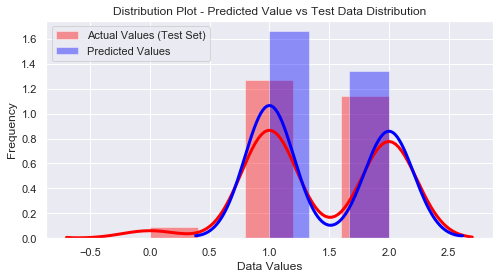

Confusion Matrix, non-normalized


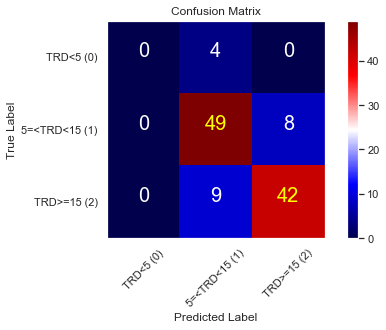

In [25]:
RedFunction = y_test_bool # Test Data Set
BlueFunction = yhat_svm # Predicted Data Set
RedName = "Actual Values (Test Set)" 
BlueName = "Predicted Values"
width = 8
height = width/2

Title = 'Distribution Plot - Predicted Value vs Test Data Distribution'
xlabel = 'Data Values'
ylabel = 'Frequency'
DistributionPlot(RedFunction, BlueFunction, RedName, 
                     BlueName, Title, width, height,
                    xlabel, ylabel, 1)

plot_conf_mat(conf_mat_svm, 
              classes=['TRD<5 (0)', 
                       '5=<TRD<15 (1)', 
                       'TRD>=15 (2)'],
              normalize=normalize, cmap=cmap, width=width, height=height)

The predicion accuracy with the SVM is >0.8, higher than the Decision Tree, making this the best model for this data set.

In [26]:
# Pickle KNN model
with open('model_KNN', 'wb') as file:
    pickle.dump(neigh, file)
    
# Pickle decision tree model
with open('model_dec_tree', 'wb') as file:
    pickle.dump(trd_tree, file)
    
# Pickle support vector machine model
with open('model_SVM', 'wb') as file:
    pickle.dump(model_svm, file)

Summarized below are the results:

| Method                   | Accuracy Score (Testing Set)|
|--------------------------|-----------------------------|
| Multi-Linear Regression  | 0.63                        |
| 2nd Order Polynomial     | 0.51                        |
| Ridge Regression         | 0.67                        |
| K Nearest Neighbour (K=5)| 0.81                        |
| Decision Tree            | 0.75                        |
| Support Vector Machine   | 0.81                        |

1. To predict actual number of days ('no_of_rainy_days'), the Ridge Regression is best. 
2. To predict grouping of days ('prob_rain'), the support vector machine is best.

#### Checkpoint

In [29]:
# Save datasets as npz
np.savez('Train_Set', inputs = X_train, targets = y_train)
np.savez('Train_Set_Bool', inputs = X_train, targets = y_train_bool)

np.savez('Test_Set', inputs = X_test, targets = y_test)
np.savez('Test_Set_Bool', inputs = X_test, targets = y_test_bool)

In [28]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 6.860185861587524 seconds
